## Predirre se qualcuno ha o non ha il Covid-19

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Antonelli Giacomo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Parte 1 - Descrizione del dataset e l'obiettivo del modello

Il [dataset scelto](https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download) contiene diverse informazioni riguardo la salute di numerosi pazienti che hanno contratto il virus del COVID-19, e del livello di rischio a cui ognuno di essi è sottoposto, ovvero quanto gravi sono stati gli effetti sul loro corpo. Il modello avrà lo scopo di definire questo livello di rischio per un paziente di cui si ha solamente le informazioni cliniche, applicato al mondo reale questo modello verrebbe usato per categorizzare i pazienti in fascie diverse, in modo da dare priorità a coloro che sono più a rischio.

Il dataset in sé contiene 1.048.576 righe (una per ogni paziente) e 21 caratteristiche elencate qui di seguito:
- sex: 1 per le femmine e 2 per i maschi.
- age: età del paziente.
- classification: risultati del test covid. I valori da 1 a 3 significano che il paziente è stato diagnosticato con covid in diversi gradi. 4 o superiore significa che il paziente non è portatore di covid o che il test è inconcludente.
- patient type: tipo di assistenza che il paziente ha ricevuto nell'unità. 1 per il ritorno a casa e 2 per l'ospedalizzazione.
- pneumonia: se il paziente ha già un'infiammazione degli alveoli o meno.
- pregnancy: se il paziente è incinta o meno.
- diabetes: se il paziente ha il diabete o meno.
- copd: indica se il paziente ha la broncopneumopatia cronica ostruttiva o meno.
- asthma: se il paziente ha l'asma o meno.
- inmsupr: se il paziente è immunosoppresso o meno.
- hypertension: se il paziente ha l'ipertensione o meno.
- cardiovascular: se il paziente ha malattie legate al cuore o ai vasi sanguigni.
- renal chronic: se il paziente ha una malattia renale cronica o meno.
- other disease: se il paziente ha altre malattie o meno.
- obesity: se il paziente è obeso o meno.
- tobacco: se il paziente è un consumatore di tabacco.
- usmr: indica se il paziente è stato trattato in unità mediche di primo, secondo o terzo livello.
- medical unit: tipo di istituzione del Sistema Sanitario Nazionale che ha fornito le cure.
- intubed: se il paziente è stato collegato al ventilatore.
- icu: indica se il paziente è stato ammesso in un'Unità di Terapia Intensiva.
- date died: se il paziente è deceduto, indica la data della morte, e 9999-99-99 altrimenti.

Non tutti i dati sono presenti all'interno del dataset (indicati dai valori tra 97 e 99), mentre i valori booleani sono rappresentati da 1=si e 2=no.

In [2]:
# Dopo aver scaricato il file, lo carichiamo in un DataFrame
data = pd.read_csv("Covid Data.csv")
initial_size = data.memory_usage(deep=True).sum()/1024**2

print(f"Forma dei dati: {data.shape}\n")

data.head()

Forma dei dati: (1048575, 21)



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Parte 2 - Analisi esplorativa
In questa parte andrò ad analizzare le varie feature e valori del dataset attraverso grafici e strumenti statistici per capirne la distribuzione ed eventuali relazioni o incongruenze

In [3]:
# Come da specifiche i dati assenti non sono rappresentati da NaN ma da numeri tra 97 e 99
print(f"Numero di NaN: {data.isna().sum().sum()}\n")

# Vado quindi a contare quanti sono i record con valori tra 97 e 99 per ogni colonna
print("Numero di record con feature tra 97 e 99:")
print(data.isin([97, 98, 99]).sum())

Numero di NaN: 0

Numero di record con feature tra 97 e 99:
USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64


Visualizzo graficamente il numero di valori validi e valori assenti per ogni colonna

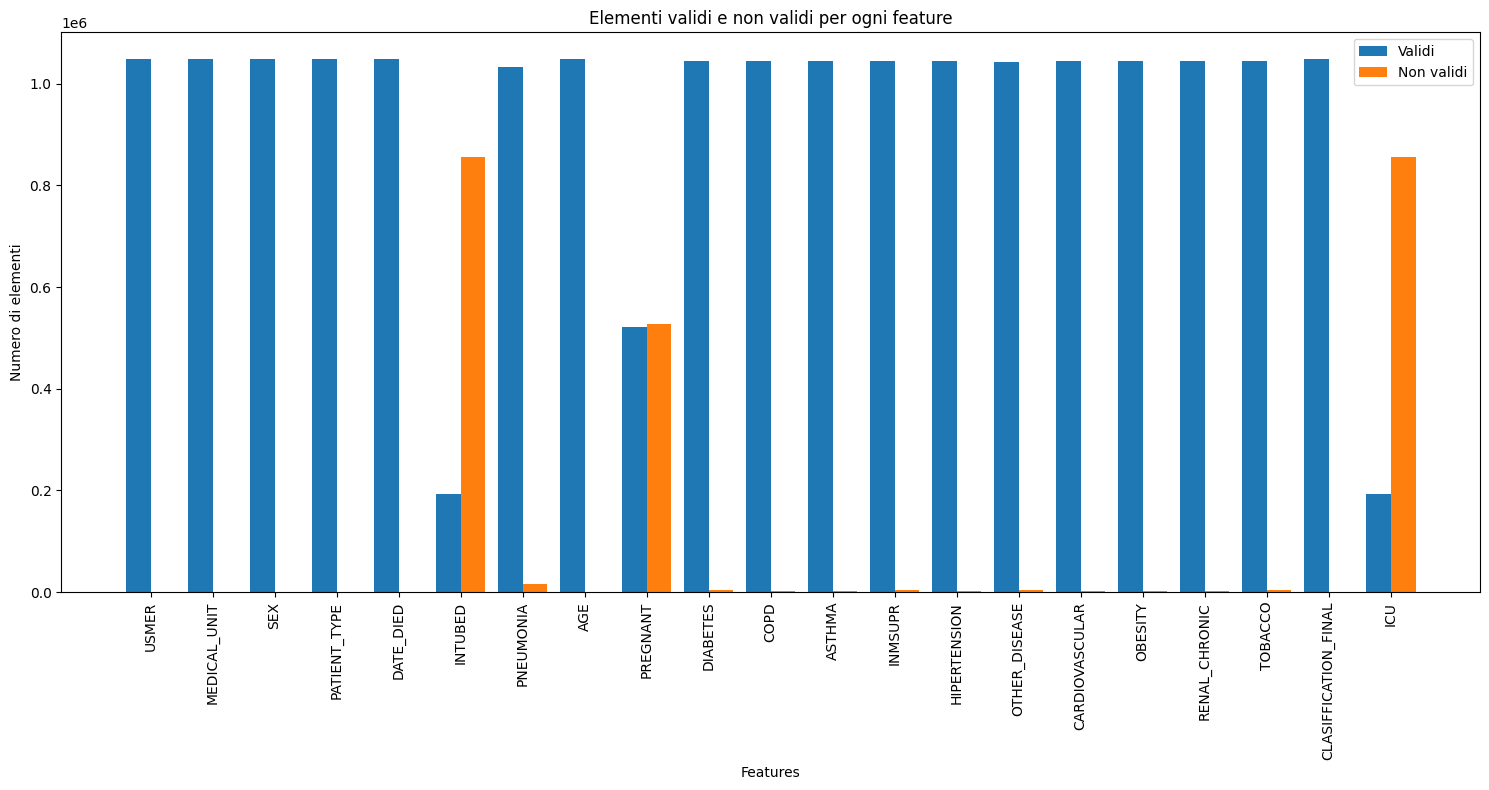

In [4]:
invalid_values = {97, 98, 99}

valid_counts = []
invalid_counts = []

for col in data.columns:
    valid_count = data[col].apply(lambda x: x not in invalid_values).sum()
    invalid_count = data[col].apply(lambda x: x in invalid_values).sum()
    valid_counts.append(valid_count)
    invalid_counts.append(invalid_count)

# Stampo il grafico dei dati ottenuti
x = np.arange(len(data.columns))
width = 0.4

# Definisco alcune proprietà del grafico
fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width/2, valid_counts, width, label='Validi')
rects2 = ax.bar(x + width/2, invalid_counts, width, label='Non validi')

ax.set_xlabel('Features')
ax.set_ylabel('Numero di elementi')
ax.set_title('Elementi validi e non validi per ogni feature')
ax.set_xticks(x)
ax.set_xticklabels(data.columns, rotation=90)
ax.legend()

fig.tight_layout()

plt.show()

Questa è la tabella che descrive le varie features del dataset:

In [5]:
print(data.describe())

              USMER  MEDICAL_UNIT           SEX  PATIENT_TYPE       INTUBED  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   1.632194e+00  8.980565e+00  1.499259e+00  1.190765e+00  7.952288e+01   
std    4.822084e-01  3.723278e+00  4.999997e-01  3.929041e-01  3.686889e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.000000e+00  4.000000e+00  1.000000e+00  1.000000e+00  9.700000e+01   
50%    2.000000e+00  1.200000e+01  1.000000e+00  1.000000e+00  9.700000e+01   
75%    2.000000e+00  1.200000e+01  2.000000e+00  1.000000e+00  9.700000e+01   
max    2.000000e+00  1.300000e+01  2.000000e+00  2.000000e+00  9.900000e+01   

          PNEUMONIA           AGE      PREGNANT      DIABETES          COPD  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   3.346831e+00  4.179410e+01  4.976558e+01  2.186404e+00  2.260569e+00   
std    1.191288e+01  1.690739e+01  4.751073e+01  5.

All'interno del dataset, essendo molti i dati e di diverso tipo, la tabella sopra elencata può risultare un po confusionaria o non dire molto, perciò mostrerò di seguito alcune delle relazioni tra le features che ritengo più interessanti:

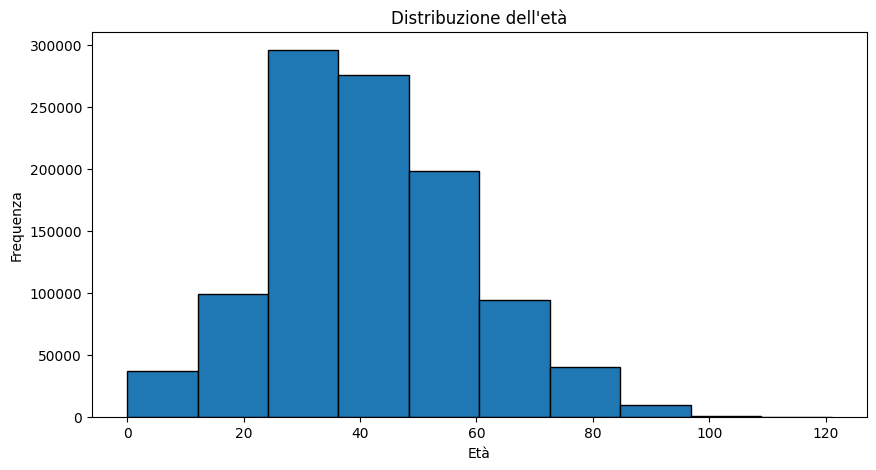

In [6]:
# Distribuzione dell'età
plt.figure(figsize=(10, 5))
data['AGE'].astype(int).plot(kind='hist', bins=10, edgecolor='k', title='Distribuzione dell\'età')
plt.xlabel('Età')
plt.ylabel('Frequenza')
plt.show()

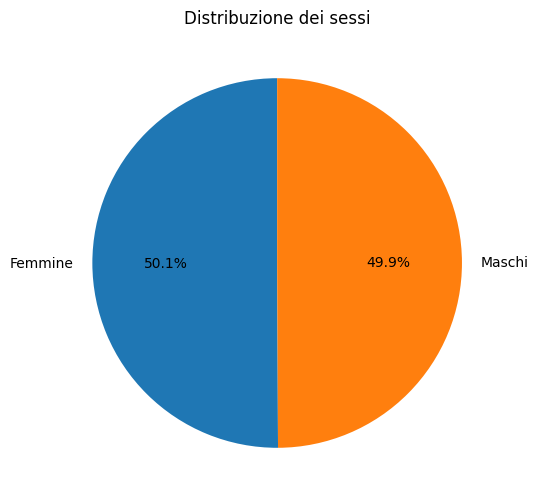

In [7]:
# Distribuzione dei sessi
plt.figure(figsize=(6, 6))
data['SEX'].value_counts().plot(kind='pie', labels=['Femmine', 'Maschi'], autopct='%1.1f%%', startangle=90, title='Distribuzione dei sessi')
plt.ylabel('')
plt.show()

In [8]:
data = pd.read_csv("Covid Data.csv")

121


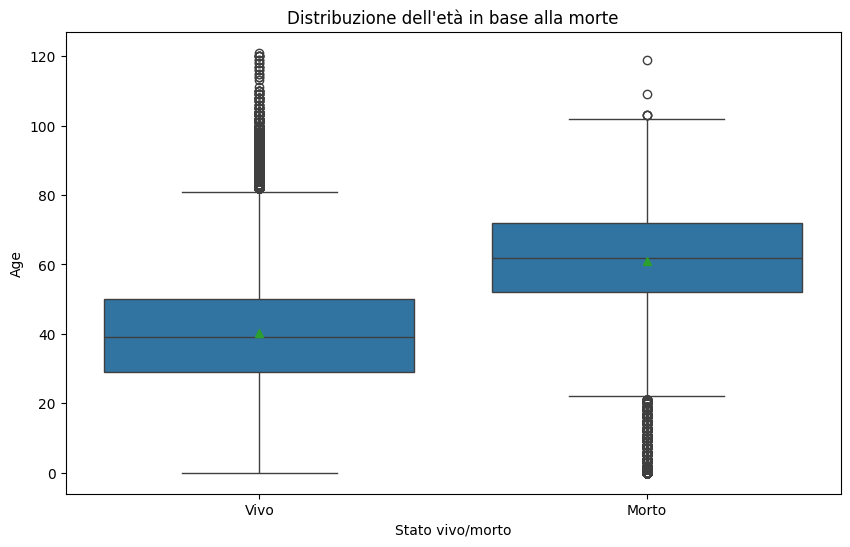

In [9]:
death_distr = data[["DATE_DIED", "AGE"]].copy()

# Converto la colonna DATE_DIED in un formato datetime per poterla utilizzare nel grafico !!!
death_distr.loc[death_distr.DATE_DIED != '9999-99-99', 'DATE_DIED'] = 'Morto'
death_distr.loc[death_distr.DATE_DIED == '9999-99-99', 'DATE_DIED'] = 'Vivo'

print(death_distr.loc[death_distr.DATE_DIED == 'Vivo'].AGE.max())
#print(death_distr.head())

# Boxplot per l'età in base alla morte
plt.figure(figsize=(10, 6))
death_distr = death_distr.sample(frac=1)
sns.boxplot(x='DATE_DIED', y='AGE', data=death_distr, showmeans=True)
plt.title('Distribuzione dell\'età in base alla morte')
plt.xlabel('Stato vivo/morto')
plt.ylabel('Age')
plt.show()

# Parte 3 - Preparare i Dati
In questa parte andrò a modificare i dati all'interno del dataframe, eliminando dati superflui o incompleti e ad ottimizzare la memoria.

Siccome le colonne INTUBED e ICU hanno per la maggior parte dei record valori non disponibili le eliminiamo dal dataframe\
PROVA A FARE UN TEST SENZA TOGLIERLE DAL DATAFRAME!!!

In [10]:
print(data.INTUBED.value_counts())
print(data.ICU.value_counts())
data.drop(columns=["INTUBED","ICU"], inplace=True)

INTUBED
97    848544
2     159050
1      33656
99      7325
Name: count, dtype: int64
ICU
97    848544
2     175685
1      16858
99      7488
Name: count, dtype: int64


Andiamo ora invece ad analizzare i valori dei dati, in modo da capire se possiamo risparmiare memoria cambiando il tipo di dato

In [11]:
for i in data.columns:
    print(i,": ",len(data[i].unique()))

USMER :  2
MEDICAL_UNIT :  13
SEX :  2
PATIENT_TYPE :  2
DATE_DIED :  401
PNEUMONIA :  3
AGE :  121
PREGNANT :  4
DIABETES :  3
COPD :  3
ASTHMA :  3
INMSUPR :  3
HIPERTENSION :  3
OTHER_DISEASE :  3
CARDIOVASCULAR :  3
OBESITY :  3
RENAL_CHRONIC :  3
TOBACCO :  3
CLASIFFICATION_FINAL :  7


Della feature DATE_DIED, non ci importa la data di decesso o meno della persona, quindi possiamo convertirlo in un binario 1=morto, 2=vivo, sostituendo la colonna DATE_DIED con DIED

In [12]:
data["DIED"] = [2 if date=="9999-99-99" else 1 for date in data.DATE_DIED]
data.drop(columns=["DATE_DIED"], inplace=True)

Riguardo alla feature PREGNANT, possiamo vedere che numerosi valori sono identificati come assenti:

In [13]:
print(data.PREGNANT.value_counts())

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64


In particolare, analizzando le feature mischiando PREGNANT e SEX, possiamo vedere come la maggior parte dei valori assenti ricadano tra i pazienti di sesso maschile, per questo motivo possiamo immetergli un valore PREGNANT uguale a 2 (False), mentre i pochi valori assenti rimanenti nei record con sesso femminile possiamo eliminarli siccome non sono un numero importante

In [14]:
male_pregnant = data.loc[data.SEX == 2, 'PREGNANT'].value_counts()
female_pregnant = data.loc[data.SEX == 1, 'PREGNANT'].value_counts()
print(f"Male pregnants:\n{male_pregnant}\n")
print(f"Female pregnants:\n{female_pregnant}\n")

# Elimino i pochi record con sesso femminile senza informazioni sulla gravidanza
data = data[~((data.SEX == 1) & (data.PREGNANT != 1) & (data.PREGNANT != 2))]

# Converto tutti i record con sesso maschile in 2 (non incinta)
data = data.replace({'PREGNANT': {97: 2, 98: 2, 99: 2}})

data.PREGNANT.value_counts()

Male pregnants:
PREGNANT
97    523511
Name: count, dtype: int64

Female pregnants:
PREGNANT
2     513179
1       8131
98      3754
Name: count, dtype: int64



PREGNANT
2    1036690
1       8131
Name: count, dtype: int64

Siccome esistono ancora alcuni record con valori assenti e sono una quantità nettamente minore, eliminiamo i record con valori tra 97 e 99. Non andiamo ad eseguire operazioni per provare a sostituire i valori assenti, poiche sono dati non riproducibili statisticamente e rischierebbe di peggiorare le prestazioni del modello finale.

In [15]:
print(f"Numero di record con feature tra 97 e 99: {data.apply(lambda col: col.isin([97, 98, 99]).sum()).sum()}")
data = data[~data.isin([97, 98, 99]).any(axis=1)]
print(data.shape)

Numero di record con feature tra 97 e 99: 47332
(1021655, 19)


Dalla stampa precedente possiamo notare che la maggior parte delle colonne ha un numero di valori unici molto basso, possiamo quindi raccoglierli in gruppi di valori definiti

In [16]:
data['USMER'] = data['USMER'].astype('category')
data['MEDICAL_UNIT'] = data['MEDICAL_UNIT'].astype('category')
data['SEX'] = data['SEX'].astype('category')
data['DIED'] = data['DIED'].astype('category')
data['PNEUMONIA'] = data['PNEUMONIA'].astype('category')
data['PREGNANT'] = data['PREGNANT'].astype('category')
data['DIABETES'] = data['DIABETES'].astype('category')
data['COPD'] = data['COPD'].astype('category')
data['ASTHMA'] = data['ASTHMA'].astype('category')
data['INMSUPR'] = data['INMSUPR'].astype('category')
data['HIPERTENSION'] = data['HIPERTENSION'].astype('category')
data['OTHER_DISEASE'] = data['OTHER_DISEASE'].astype('category')
data['CARDIOVASCULAR'] = data['CARDIOVASCULAR'].astype('category')
data['OBESITY'] = data['OBESITY'].astype('category')
data['RENAL_CHRONIC'] = data['RENAL_CHRONIC'].astype('category')
data['TOBACCO'] = data['TOBACCO'].astype('category')
data['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'].astype('category')

In [17]:
final_size = data.memory_usage(deep=True).sum()/1024**2

saved_memory = initial_size - final_size
saved_memory_percentage = (saved_memory / initial_size) * 100

print(f"Quantità di memoria risparmiata: {saved_memory:.2f} MB ({saved_memory_percentage:.2f}%)")

Quantità di memoria risparmiata: 179.05 MB (81.76%)


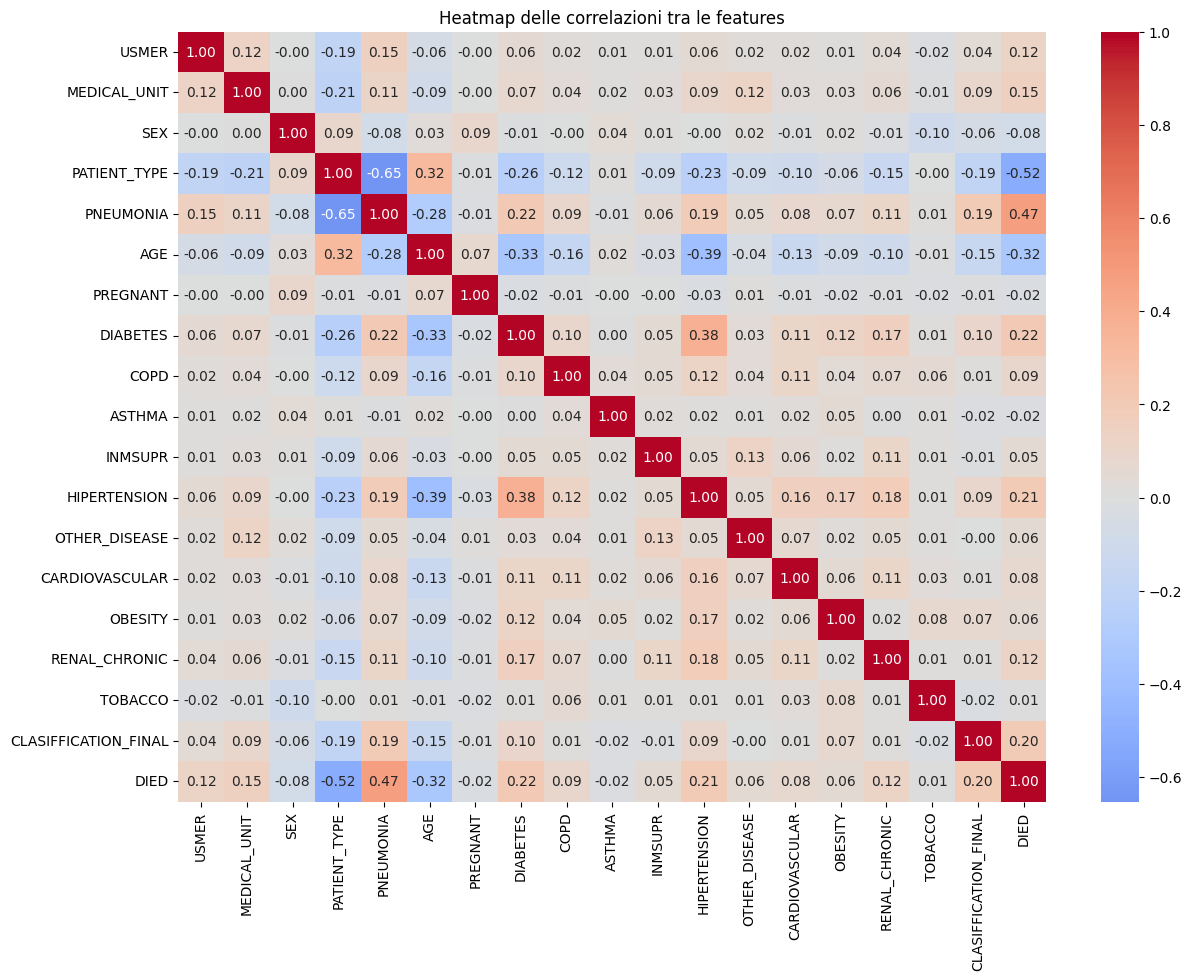

In [18]:
# Heatmap delle correlazioni tra le features
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Heatmap delle correlazioni tra le features')
plt.show()

# 4 - Addestramento e Validazione dei Modelli

Gestisco le variabili categorice attraverso un one-hot encode, abilitando il parametro drop_first in modo da evitare **multicollinearità** !!!

In [19]:
#data = pd.get_dummies(data,columns=["USMER", "MEDICAL_UNIT", "SEX", "PNEUMONIA", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO"],drop_first=True)

In [20]:
print(data.columns)
print(data.shape)
data_part = data[:200000]

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE',
       'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL', 'DIED'],
      dtype='object')
(1021655, 19)


In [22]:
%pip install cuml

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build cuml
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for cuml (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running bdist_wheel
      running build
      installing to build\bdist.win-amd64\wheel
      running install
      Traceback (most recent call last):
        File "c:\Users\giaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\giaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\giaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 251, in build_wheel
          return _build_backend().build_wheel

In [23]:
import cudf
import cuml
import xgboost as xgb
from cuml.preprocessing.LabelEncoder import LabelEncoder
from cuml.preprocessing.TargetEncoder import TargetEncoder
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.experimental.preprocessing import StandardScaler
from cuml.metrics import accuracy_score, confusion_matrix
from cuml.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Convert your pandas dataframe to cudf dataframe for GPU acceleration
data_part = cudf.DataFrame.from_pandas(data_part)

# Separate features and target variable
X = data_part.drop('CLASIFFICATION_FINAL', axis=1)
y = data_part['CLASIFFICATION_FINAL']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: Label encode categorical variables and scale numerical variables
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Scaling numerical features
for col in numerical_cols:
    scl = StandardScaler()
    X[col] = scl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and their respective hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['qn']  # 'qn' is the only solver available for cuml's LogisticRegression
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': xgb.XGBClassifier(tree_method='gpu_hist', random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

best_estimators = {}
best_scores = {}

# Perform GridSearchCV for each model
for model_name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train.to_pandas(), y_train.to_pandas())
    best_estimators[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

# Evaluate the best model from each grid search on the test set
for model_name, best_estimator in best_estimators.items():
    y_pred = best_estimator.predict(X_test.to_pandas())
    accuracy = accuracy_score(y_test.to_pandas(), y_pred)
    conf_matrix = confusion_matrix(y_test.to_pandas(), y_pred)
    print(f"\n{model_name} Test Set Evaluation:")
    print(f"Accuracy: {accuracy}")
    print('Confusion Matrix:')
    print(conf_matrix)


ModuleNotFoundError: No module named 'cudf'